<a href="https://colab.research.google.com/github/sebastianJamesMI/Fellowship_AI_IMDB/blob/main/Sentiment_Analysis_IMDB_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses the IMDB dataset compiled by Andrew Maas (see http://a
i.stanford.edu/~amaas/data/sentiment/).

- The objective is to classify movie reviews as positive or negative. The original reviews were rated on a scale from 1 to 10. For Binary Classification, anything with <= 4 was classfed as negative and anything with >= 7 stars were classified as positive. 



I use different strategies to perform this classification task starting with a simple Baseline then using more complex models. This notebook uses a simple Baseline model and references the following sources:
1. Data reading and downloading, Aaron Kub: 
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
2. Data Reading and Downloading: Georgios Drakos: https://gdcoder.com/sentiment-clas/
2. Word Tokenization: Coursera Deep learning NLP courses by Andrew Ng


Download the data from http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
!gunzip aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar

In [ ]:
## Actual Analysis
import numpy as np
import pandas as pd
from glob import glob
import os
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ls

aclImdb/  aclImdb_v1.tar  drive/  sample_data/


In [ ]:
## Read this data into python
PATH = '/content/aclImdb/'
names = ['neg', 'pos']

In [ ]:
def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    # stored as np.int8 to save space 
    return texts, np.array(labels).astype(np.int8)

train_x,train_y = load_texts_labels_from_folders(f'{PATH}train',names)
test_x,test_y = load_texts_labels_from_folders(f'{PATH}test',names)


0 neg
0 neg


In [ ]:
len(train_x),len(train_y),len(test_x),len(test_y)

(25000, 25000, 25000, 25000)

In [ ]:
#create train.csv and test.csv pd files for easier access
train = pd.DataFrame(zip(train_x, train_y), columns = ['text', 'label'])
test = pd.DataFrame(zip(test_x, test_y), columns = ['text', 'label'])
train.to_csv('/content/drive/MyDrive/Projects/FellowshipAI/train.csv', index= False)
test.to_csv('/content/drive/MyDrive/Projects/FellowshipAI/test.csv', index= False)

In [ ]:
## Read in train and test files, we can use these filesn for future notebooks
train_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/test.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(25000, 2)
(25000, 2)


In [ ]:
## An example of training data
print('The review text is: {}'.format(train_df['text'][0]))
print('\n')
print(f"The label is: {train_df['label'][0]}")

The review text is: BRIEF ENCOUNTER is a ghastly and pointless remake of the 1945 David Lean classic, which was based on Noel Coward's play "Still Life". A doctor removes a particle of grit from a woman's eye at a railway station, he is in a miserable relationship, she is happily married social worker of Italian ancestry. They meet by accident on another occasion, form an instant attraction and arrange to meet each other every Wednesday. The pair fall in love, but after spending a few afternoons together they realise that they have no realistic chance of happiness and agree to part. Coward's original one-act play concerned two ordinary people who fall in love. Sophia Loren and Richard Burton, two Super Stars and veterans of Hollywood Epics, are nobody's idea of 'ordinary people'. Loren in particular is miscast - Sophia Loren in full make-up, looking like a million dollars, working as a part-time voluntary social worker at a Citizen Advice Bureau just doesn't ring true. Burton, looking 

In [ ]:
## split the training data further into trian and validation
train, val = train_test_split(train_df, test_size=0.2)
test = test_df

In [ ]:
val.head()

,text,label
561,This film essentially deals with Inspector Gad...,0
19856,I went to see this movie twice within a week a...,1
21370,Gómez Pereira is the responsible for some of t...,1
23242,This film was quite a surprise. I wasn't expec...,1
18081,This is a really nice and sweet movie that the...,1


In [ ]:
val['text'].iloc[0]

'This film essentially deals with Inspector Gadget\'s arch-nemesis Doctor Claw who has returned after many years to the now-peaceful city of Metropolis. Claw\'s plan is to foil Gadget once and for all by using a newer "cooler" crimefighter to help destroy Gadget\'s popularity. Sadly the film fails miserably, the series was great, but it was revived nearly 20 years later with tragic results. Without the voice of Don Adams as Inspector Gadget it just doesn\'t cut it anymore; Dr. Claw is not only visually less frightening, but sounds more like a wrestler with a cold, than his original intimidating self. Granted this is a children\'s movie, but the plot is so painfully weak (heaven forbid I mention the animation) that it pales in comparison to the original series. Someone has decided to updated Penny as well to bring her two decades up to speed, she now has some quasi-punk rebellious clothing style and doesn\'t play half the role that she did in the TV series. The Gadgetmobile talks, as we

In [ ]:
## This model is a Baseline Using an Simple Neural Network with no RNN layers to predict sentiment

In [ ]:
## Text data needs to be converted to numerical data using tokenizing

In [ ]:
vocab_size = 50000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
# we use tensorflow tokenizer which will do some preprocessing
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index  ## this is the dictionary storing word: token pairs

In [ ]:
len(word_index)

80306

In [ ]:
#converting text to number (token) sequences and padding, the inputs need to be of same dimension
train_sequences = tokenizer.texts_to_sequences(train['text'])
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type, padding='post')

val_sequences = tokenizer.texts_to_sequences(val['text'])
val_padded = pad_sequences(val_sequences,maxlen=max_length, truncating=trunc_type, padding='post')

test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating=trunc_type, padding='post')

In [ ]:
print(train_sequences[0])
print(train_padded[0])

[363, 301, 387, 6, 70, 52, 11, 14, 42, 821, 11, 381, 319, 811, 1116, 5, 5055, 1507, 340, 3581, 16, 2031, 12517, 3, 29, 250, 59, 1647, 580, 70, 13, 28, 14, 79, 9, 4, 120, 440, 363, 301, 29, 250, 11, 14, 2009, 192, 6, 1289, 33, 370, 136, 5130, 221, 10, 161, 309, 97, 216, 31, 84, 19, 15, 11, 293, 51, 3, 51, 123, 312, 31, 821, 4363, 11, 60, 41, 27, 37, 83, 10, 8, 8, 12, 120, 62, 164, 23, 184, 6, 27, 47, 625, 3445, 44, 16, 2, 531, 139, 1361, 16, 95, 3, 276, 57, 2873, 9, 66, 116, 221, 1876, 47133, 8, 8, 2, 152, 11, 38, 89, 42, 363, 301, 7, 13, 43, 4, 82, 120, 17, 359, 3, 1532, 5, 30, 2114, 47, 78, 27, 48, 538, 13, 24, 51, 17, 1532, 94, 538, 13, 24, 950, 17, 359, 37, 13, 2, 225, 221, 78, 350, 10, 56, 549, 87, 938, 10, 68, 27, 43, 128, 4, 82, 120, 3, 11, 60, 409, 383, 10, 6, 260, 8, 8, 155, 155]
[  363   301   387     6    70    52    11    14    42   821    11   381
   319   811  1116     5  5055  1507   340  3581    16  2031 12517     3
    29   250    59  1647   580    70    13    28    14 

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(val_padded[0]))
print(val['text'].iloc[0])

this film essentially deals with inspector gadget's arch nemesis doctor claw who has returned after many years to the now peaceful city of metropolis claw's plan is to foil gadget once and for all by using a newer cooler <OOV> to help destroy gadget's popularity sadly the film fails miserably the series was great but it was revived nearly 20 years later with tragic results without the voice of don adams as inspector gadget it just doesn't cut it anymore dr claw is not only visually less frightening but sounds more like a wrestler with a cold than his original intimidating self granted this is a children's movie but the plot is so painfully weak heaven forbid i mention the
This film essentially deals with Inspector Gadget's arch-nemesis Doctor Claw who has returned after many years to the now-peaceful city of Metropolis. Claw's plan is to foil Gadget once and for all by using a newer "cooler" crimefighter to help destroy Gadget's popularity. Sadly the film fails miserably, the series wa

In [ ]:
# set model parameters here
EPOCHS = 20
BATCH_SIZE = 64

In [ ]:
#convert to tf.Data
def get_df(padded, labels):
    tempx = padded
    tempy = labels
    
    datasetx = tf.data.Dataset.from_tensor_slices(tempx)
    datasety = tf.data.Dataset.from_tensor_slices(tempy)
      
    datasets = tf.data.Dataset.zip((datasetx, datasety))
    datasets = datasets.batch(batch_size = BATCH_SIZE)
 
    return datasets

In [ ]:
train_ds = get_df(train_padded, train_y)
val_ds = get_df(val_padded, val_y)
test_ds = get_df(test_padded, test_y)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 120), dtype=tf.int32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
for x, y in train_ds.take(1):
    print(f'The text for this example is: \n {x[0]}')
    print(f'The label for this example is: \n {y[0]}')

The text for this example is: 
 [  363   301   387     6    70    52    11    14    42   821    11   381
   319   811  1116     5  5055  1507   340  3581    16  2031 12517     3
    29   250    59  1647   580    70    13    28    14    79     9     4
   120   440   363   301    29   250    11    14  2009   192     6  1289
    33   370   136  5130   221    10   161   309    97   216    31    84
    19    15    11   293    51     3    51   123   312    31   821  4363
    11    60    41    27    37    83    10     8     8    12   120    62
   164    23   184     6    27    47   625  3445    44    16     2   531
   139  1361    16    95     3   276    57  2873     9    66   116   221
  1876 47133     8     8     2   152    11    38    89    42   363   301]
The label for this example is: 
 1


In [ ]:
#set callbacks: Early Stopping and Reduce Learning Rate
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks should be instantiated according to the above requirements.
    """
    early_stopping = EarlyStopping(patience = 5, mode = 'min')
    learning_rate_reduction = ReduceLROnPlateau(factor=0.2, patience =3)
    return (early_stopping,learning_rate_reduction)

early_stopping, learning_rate_reduction = get_callbacks()
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Projects/FellowshipAIweights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')

In [ ]:
#Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 120, 16)           800000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                19210     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 819,221
Trainable params: 819,221
Non-trainable params: 0
_________________________________________________________________


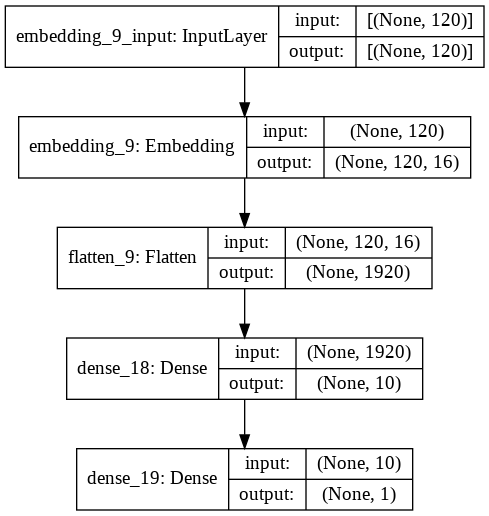

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
num_epochs = 10
history = model.fit(train_ds, validation_data = val_ds, epochs=num_epochs, shuffle = True, callbacks = [early_stopping,learning_rate_reduction, checkpoint])

Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6650 - accuracy: 0.5680 - val_loss: 0.3839 - val_accuracy: 0.8242

Epoch 00001: val_loss improved from inf to 0.38390, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 0.3066 - accuracy: 0.8728 - val_loss: 0.3484 - val_accuracy: 0.8498

Epoch 00002: val_loss improved from 0.38390 to 0.34838, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 3/10
313/313 [==============================] - 4s 11ms/step - loss: 0.1072 - accuracy: 0.9689 - val_loss: 0.3968 - val_accuracy: 0.8422

Epoch 00003: val_loss did not improve from 0.34838
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0266 - accuracy: 0.9960 - val_loss: 0.4241 - val_accuracy: 0.8498

Epoch 00004: val_loss did not improve from 0.34838
Epoch 5/10
313/313 [==============================] - 4s 11ms/step - los

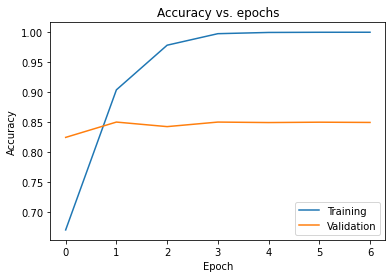

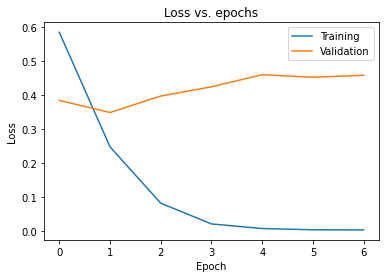

In [ ]:
## plot the loss curves
#Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
##Predict the test values

In [ ]:
predicted_values = model.predict(test_ds)

In [ ]:
predicted_values = (predicted_values>0.5).astype('int32')

In [ ]:
accuracy_score(test_y, predicted_values)

0.8102